In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import unzip_integrate as ui
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import numpy as np
from torch import Tensor

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20
learning_rate = 5e-4
weight_decay = 1e-5
momentum = 0.999

In [3]:
# # unzip and integrate all images
# image_folder_path = "CCAgT/images/"
# output_folder_path = "unzip_img"
# ui.unzip(image_folder_path, output_folder_path)
# image_folder_path = "CCAgT/masks/"
# output_folder_path = "unzip_masks"
# ui.unzip(image_folder_path, output_folder_path)

# source_folder_base = 'unzip_img'
# target_folder = 'integrate_img'
# source_folders = [os.path.join(source_folder_base, folder) for folder in os.listdir(source_folder_base) if os.path.isdir(os.path.join(source_folder_base, folder))]
# ui.integrate(source_folders, target_folder)
# source_folder_base = 'unzip_masks'
# target_folder = 'integrate_masks'
# source_folders = [os.path.join(source_folder_base, folder) for folder in os.listdir(source_folder_base) if os.path.isdir(os.path.join(source_folder_base, folder))]
# ui.integrate(source_folders, target_folder)

In [4]:
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

In [5]:
# split
image_folder = "integrate_img"
masks_folder = "integrate_masks"
image_list = os.listdir(image_folder)
masks_list = os.listdir(masks_folder)
train_images, test_images, train_masks, test_masks = train_test_split(image_list, masks_list, test_size=0.3, random_state=61)
validation_images, test_images, validation_masks, test_masks = train_test_split(test_images, test_masks, test_size=2/3, random_state=61)

# test aligned
train_images_sample = train_images[:4] 
validation_images_sample = validation_images[:4] 
test_images_sample = test_images[:4] 
train_masks_sample = train_masks[:4] 
validation_masks_sample = validation_masks[:10] 
test_masks_sample = test_masks[:10] 

print(f'{train_images_sample}\n{train_masks_sample}\n{validation_images_sample}\n{validation_masks_sample}\n{test_images_sample}\n{test_masks_sample}')

['A_10458_-299520_93960.jpg', 'F_5691_-243360_65880.jpg', 'N_14386_-149760_143640.jpg', 'H_11308_-259200_101520.jpg']
['A_10458_-299520_93960.png', 'F_5691_-243360_65880.png', 'N_14386_-149760_143640.png', 'H_11308_-259200_101520.png']
['L_16552_-159840_168480.jpg', 'A_14803_-302400_123120.jpg', 'G_8844_-249120_85320.jpg', 'D_4294_-148320_56160.jpg']
['L_16552_-159840_168480.png', 'A_14803_-302400_123120.png', 'G_8844_-249120_85320.png', 'D_4294_-148320_56160.png', 'N_16812_-181440_162000.png', 'M_8423_-262080_110160.png', 'C_3897_-201600_51840.png', 'H_14705_-233280_124200.png', 'K_5575_-141120_70200.png', 'A_15124_-302400_125280.png']
['A_10611_-311040_95040.jpg', 'A_9182_-292320_85320.jpg', 'K_1256_-272160_39960.jpg', 'D_11658_-142560_105840.jpg']
['A_10611_-311040_95040.png', 'A_9182_-292320_85320.png', 'K_1256_-272160_39960.png', 'D_11658_-142560_105840.png', 'K_7645_-204480_85320.png', 'A_4429_-224640_52920.png', 'D_10630_-240480_99360.png', 'D_15493_-149760_131760.png', 'L_10380

In [6]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([800, 800], interpolation=Image.BILINEAR),
])
mask_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize([800, 800], interpolation=Image.NEAREST),
])


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, masks):
        self.data = data
        self.masks = masks

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = "integrate_img/"+self.data[idx]
        masks_path = "integrate_masks/"+self.masks[idx]
        img = Image.open(img_path)
        masks = Image.open(masks_path)
        img = image_transform(img)
        masks = mask_transform(masks)

        

        return img, masks


train_dataset = CustomDataset(train_images, train_masks)
validation_dataset = CustomDataset(validation_images, validation_masks)
test_dataset = CustomDataset(test_images, test_masks)

sample_data, sample_label = train_dataset.__getitem__(0)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)


numpy_array = sample_label.numpy()

# 查看唯一值
unique_values = set(numpy_array.flatten().tolist())
print(f"Unique values in the tensor: {unique_values}")


Unique values in the tensor: {0, 1, 2, 3}


c:\Users\jywun\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(1024, 512))
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

def pixel_accuracy( pred, target):
    correct = (pred == target).sum().item()
    total = (target >= 0).sum().item()
    return correct / total if total > 0 else 0

def mean_pixel_accuracy( pred, target):
    num_classes=8
    class_correct = (pred == target) & (target >= 0)
    class_total = (target >= 0)

    class_acc_list = []
    for i in range(num_classes):
        class_correct_i = class_correct[target == i].sum().item()
        class_total_i = class_total[target == i].sum().item()
        class_acc_i = class_correct_i / class_total_i if class_total_i > 0 else 0
        class_acc_list.append(class_acc_i)

    mean_pixel_acc = sum(class_acc_list) / num_classes

    return mean_pixel_acc

def intersectionAndUnion(gen_mask, input_mask):
    numClass = 8
    gen_mask = gen_mask * (input_mask > 0).astype(np.int64)
    intersection = gen_mask * (gen_mask == input_mask).astype(np.int64)
    area_intersection, _ = np.histogram(intersection, bins=numClass, range=(1, numClass))
    area_union, _ = np.histogram(gen_mask, bins=numClass, range=(1, numClass))
    return None, area_intersection, area_union



def mIoU(gen_mask, input_mask):
    area_intersection = []
    area_union = []

    for i in range(input_mask.shape[0]):
        _, intersection, union = intersectionAndUnion(gen_mask[i], input_mask[i])
        area_intersection.append(intersection)
        area_union.append(union)

    IoU = 1.0 * np.sum(area_intersection, axis=0) / np.sum(np.spacing(1)+area_union, axis=0)

    return np.mean(IoU)

EPS = 1e-10
def nanmean(x):
    return torch.mean(x[x == x])

def _fast_hist(true, pred, num_classes):
    mask = (true >= 0) & (true < num_classes)
    true = torch.from_numpy(true[mask]).to(torch.int)
    pred = torch.from_numpy(pred[mask]).to(torch.int)
    hist = torch.bincount(
        num_classes * true + pred,
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()
    return hist



def per_class_pixel_accuracy(hist):
    correct_per_class = torch.diag(hist)
    total_per_class = hist.sum(dim=1)
    per_class_acc = correct_per_class / (total_per_class + EPS)
    avg_per_class_acc = nanmean(per_class_acc)
    return avg_per_class_acc, per_class_acc

def per_class_PA (pred, label):
    hist = _fast_hist(pred, label,8)
    avg, per = per_class_pixel_accuracy(hist)
    return avg, per




In [10]:
model = UNet(n_channels=3, n_classes=8)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  
criterion = nn.CrossEntropyLoss()

In [11]:
def validation(model, validation_dataloader):
    model.eval().to(device)  
    epoch_loss = 0

    with torch.no_grad():  
        for _, data in enumerate(validation_dataloader):
            images, masks = data[0].to(device), data[1].to(device)

            masks_pred = model(images).to(device)
            masks = masks.squeeze(dim=1)
            masks = masks.long()

            loss = criterion(masks_pred, masks)
            dice_loss_value = dice_loss(F.softmax(masks_pred, dim=1).float(),F.one_hot(masks, 8).permute(0, 3, 1, 2).float(),multiclass=True)
            loss = loss + dice_loss_value

            epoch_loss += loss.item()

        avg_batch_loss = epoch_loss / len(validation_dataloader)

    return avg_batch_loss


In [12]:
loss_record = []
validation_loss_record = []
best = 1000
for epoch in range(1, epochs + 1):
        model.train().to(device)
        epoch_loss = 0
        loop = tqdm(train_dataloader, total = len(train_dataloader))
        
        for _, data in enumerate(loop):
                loop.set_description(f'Epoch [{epoch}/{epochs}]')
                
                images, masks = data[0].to(device), data[1].to(device)
                
                optimizer.zero_grad()
                
                masks_pred = model(images).to(device)
                masks = masks.squeeze(dim=1)
                masks = masks.long()
                

                loss = criterion(masks_pred, masks)
                dice_loss_value = dice_loss(F.softmax(masks_pred, dim=1).float(),F.one_hot(masks, 8).permute(0, 3, 1, 2).float(),multiclass=True)
                loss = loss + 1.5*dice_loss_value

                loss.backward()
                optimizer.step()
                current_learning_rate = optimizer.param_groups[0]['lr']
        
        
                epoch_loss += loss.item()
                        

                loop.set_postfix(loss=loss.item(), LR=f'{current_learning_rate:.8f}')

        
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        loss_record.append(avg_epoch_loss)

        validation_loss = validation(model, validation_dataloader)
        validation_loss_record.append(validation_loss)
        
        if validation_loss<best:
                best=validation_loss
                torch.save(model.state_dict(), f'checkpoint/model_checkpoint_epoch.pth')
                torch.save(loss_record, f'checkpoint/loss_record_epoch.pkl')
                torch.save(validation_loss_record, f'checkpoint/validation_loss_record_epoch.pkl')
                torch.save(optimizer.state_dict(), f'checkpoint/optimizer_state_epoch.pth')

        scheduler.step(validation_loss)




Epoch [20/20]: 100%|██████████| 1635/1635 [12:04<00:00,  2.26it/s, LR=0.00000050, loss=0.0177] 


In [19]:

model.eval().to(device) 
with torch.no_grad():

    pixel_acc_list = []
    mean_pixel_acc_list = []
    miou_list = []
    per_class_pa_list = []
    loop = tqdm(test_dataloader, total = len(test_dataloader))
    for _, data in enumerate(loop):
        images, masks = data[0].to(device), data[1].to(device)
        masks_pred = model(images).to(device)
        masks = masks.squeeze(dim=1)
        masks = masks.long()
        


        _,predicted = torch.max(masks_pred, 1)
        predicted = predicted.cpu().numpy()
        masks = masks.cpu().numpy()


        pixel_acc = pixel_accuracy(predicted, masks)
        mean_pixel_acc = mean_pixel_accuracy(predicted, masks)
        mIoUa = mIoU(predicted, masks)
        per_class_pa_avg, _ = per_class_PA(predicted, masks)


        pixel_acc_list.append(pixel_acc)
        mean_pixel_acc_list.append(mean_pixel_acc)
        miou_list.append(mIoUa)
        per_class_pa_list.append(per_class_pa_avg.item())

        

    avg_pixel_acc = sum(pixel_acc_list) / len(pixel_acc_list)
    avg_mean_pixel_acc = sum(mean_pixel_acc_list) / len(mean_pixel_acc_list)
    avg_miou = sum(miou_list) / len(miou_list)
    avg_per_class_pa = sum(per_class_pa_list) / len(per_class_pa_list)

    print(f'Average Pixel Accuracy: {avg_pixel_acc}')
    print(f'Average Mean Pixel Accuracy: {avg_mean_pixel_acc}')
    print(f'Average mIoU: {avg_miou}')
    print(f'Average Per-Class Pixel Accuracy: {avg_per_class_pa}')

100%|██████████| 467/467 [02:07<00:00,  3.67it/s]

Average Pixel Accuracy: 0.9957091525026771
Average Mean Pixel Accuracy: 0.3248060435308401
Average mIoU: 0.27720779340464163
Average Per-Class Pixel Accuracy: 0.36541016626409084


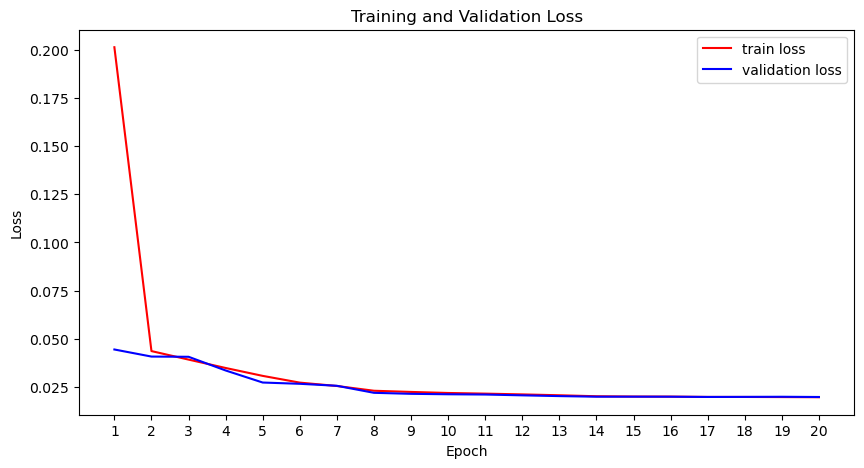

In [20]:
plt.figure(figsize=(10, 5))

plt.plot(range(1, len(loss_record) + 1), loss_record, 'r', label='train loss')
plt.plot(range(1, len(validation_loss_record) + 1), validation_loss_record, 'b', label='validation loss')

plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.xticks(range(1, len(loss_record) + 1))

plt.show()

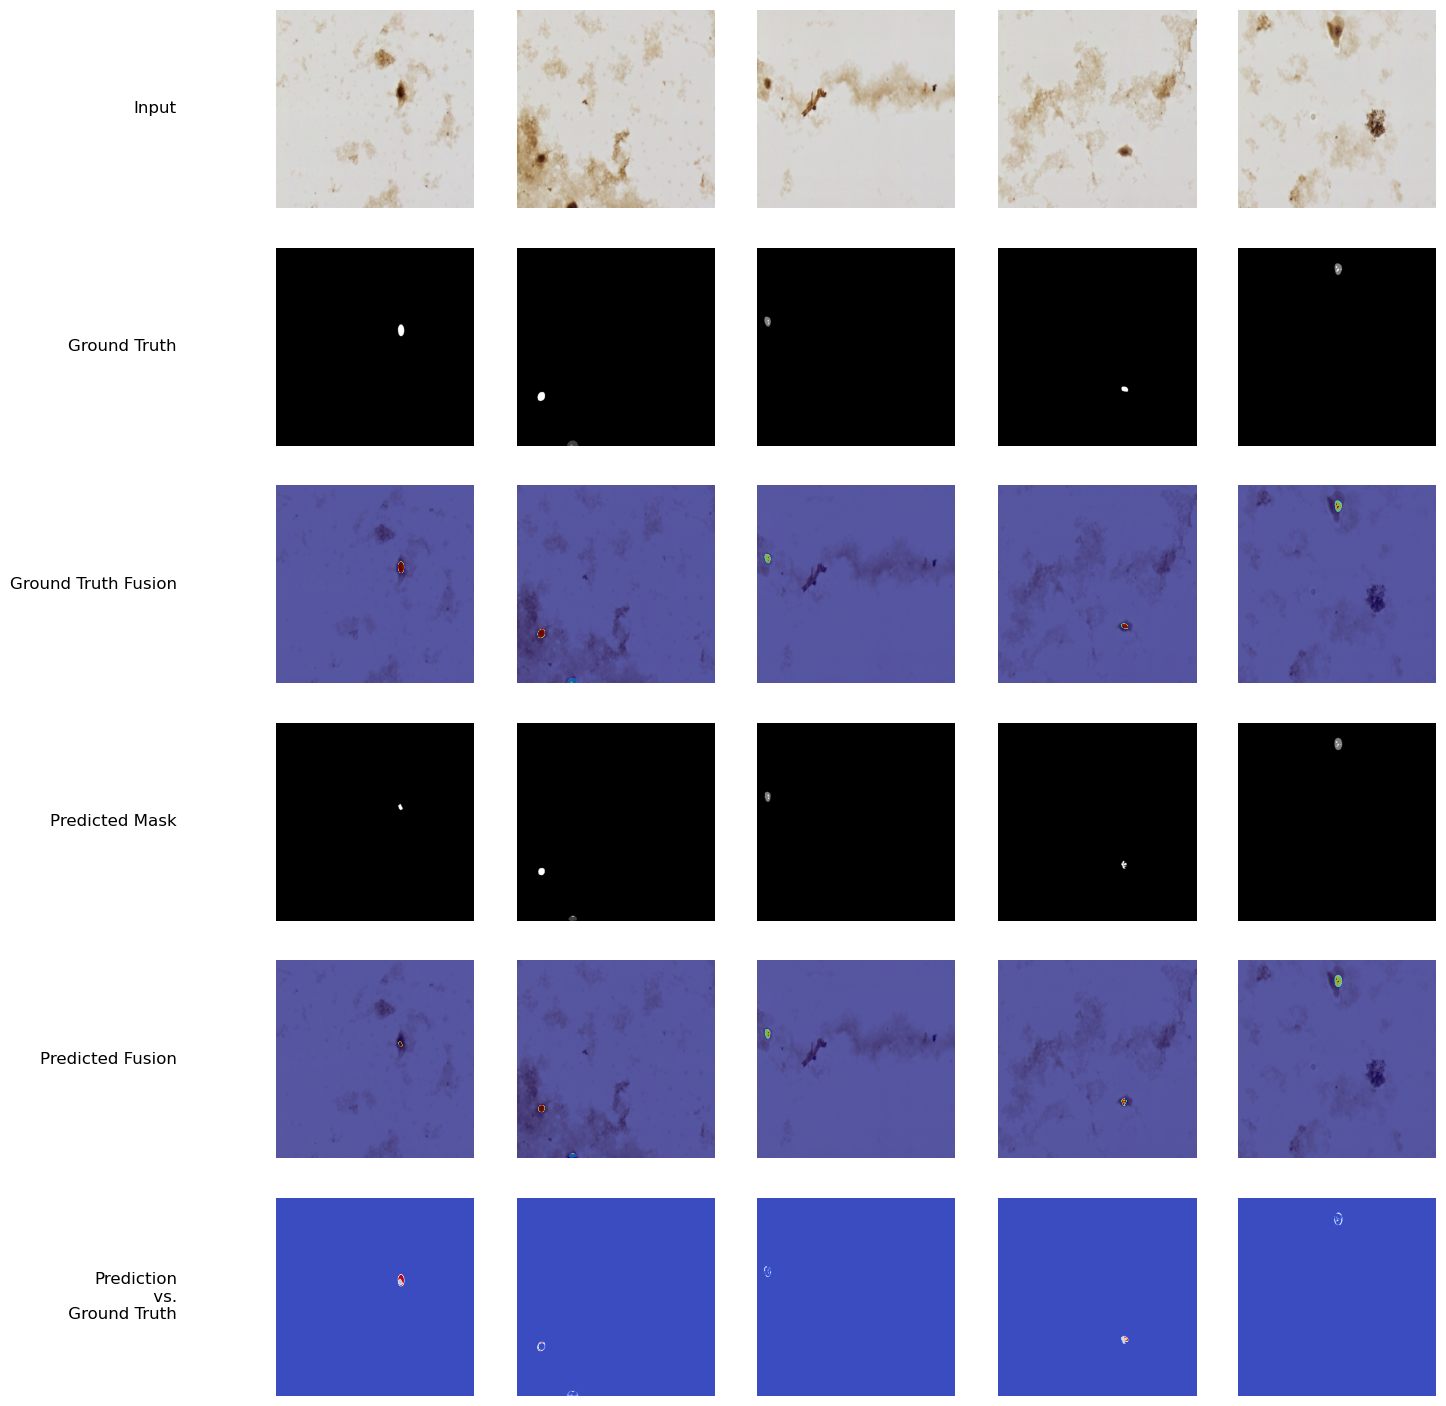

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
rand_list=[]
model.eval()
with torch.no_grad():
    fig, axs = plt.subplots(6, 5, figsize=(15, 18))  
    
    for i in range(5):  
        random_number = random.randint(1,1868)
        rand_list.append(random_number)
        image, masks = test_dataset[random_number]
        image = image.unsqueeze(0).to(device)  
        masks_pred = model(image)

        prob = torch.softmax(masks_pred, dim=1)
        predicted_mask = torch.argmax(prob, dim=1).squeeze(0).cpu().numpy()

        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)

        axs[0, i].imshow(image_np)
        axs[0, i].axis('off')

        axs[1, i].imshow(masks.squeeze(), cmap='gray')
        axs[1, i].axis('off')

        axs[2, i].imshow(image_np)
        axs[2, i].imshow(masks.squeeze(), cmap='jet', alpha=0.6)
        axs[2, i].axis('off')

        axs[3, i].imshow(predicted_mask, cmap='gray')
        axs[3, i].axis('off')

        axs[4, i].imshow(image_np)
        axs[4, i].imshow(predicted_mask, cmap='jet', alpha=0.6)
        axs[4, i].axis('off')

        difference = np.abs(masks.squeeze() - predicted_mask)
        axs[5, i].imshow(difference, cmap='coolwarm')
        axs[5, i].axis('off')

    labels = ['Input', 'Ground Truth', 'Ground Truth Fusion', 'Predicted Mask', 'Predicted Fusion', 'Prediction\n vs.\n Ground Truth']
    for i, label in enumerate(labels):
        axs[i, 0].annotate(label, xy=(-0.5, 0.5),
                    xycoords='axes fraction', xytext=(0, 0), textcoords='offset points',
                    fontsize=12, ha='right', va='center')

    plt.show()


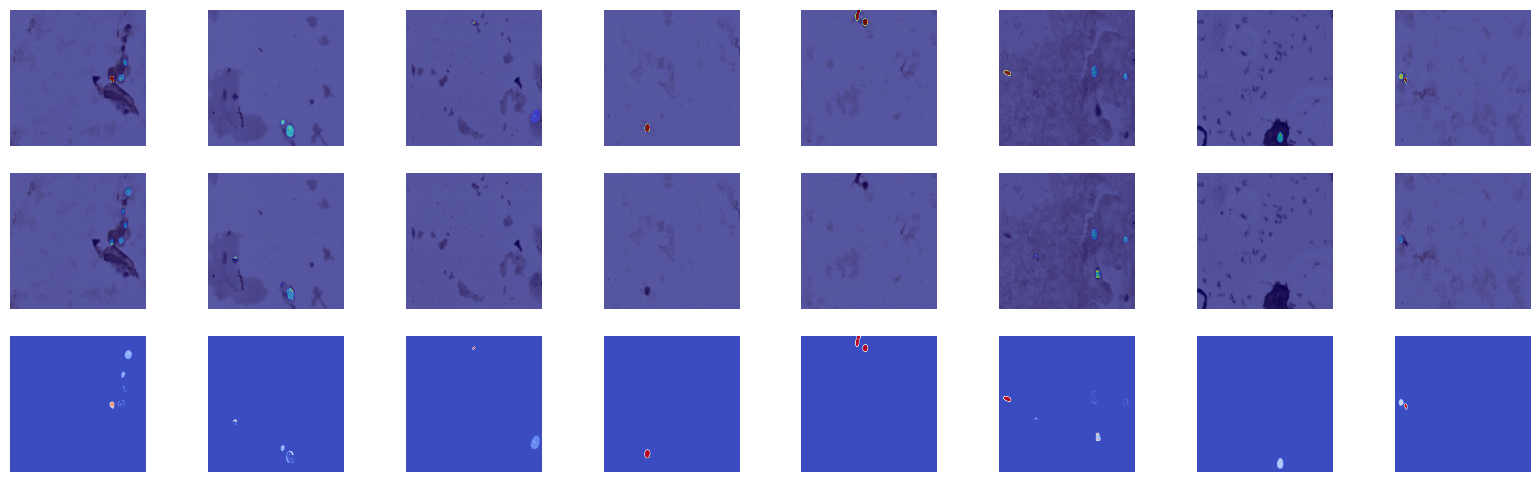

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()
with torch.no_grad():
    fig, axs = plt.subplots(3, 8, figsize=(20, 6)) 
    
    for i in range(8):  
        image, masks = test_dataset[i+21]  
        image = image.unsqueeze(0)
        masks_pred = model(image)  

        prob = torch.softmax(masks_pred, dim=1)
        predicted_mask = torch.argmax(prob, dim=1).squeeze(0).cpu().numpy()

        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    
        axs[0, i].imshow(image_np)
        axs[0, i].imshow(masks.squeeze(), cmap='jet', alpha=0.6)
        axs[0, i].axis('off')
        
        axs[1, i].imshow(image_np)
        axs[1, i].imshow(predicted_mask, cmap='jet', alpha=0.6)
        axs[1, i].axis('off')

        difference = np.abs(masks.squeeze() - predicted_mask)
        axs[2, i].imshow(difference, cmap='coolwarm')
        axs[2, i].axis('off')


    plt.show()


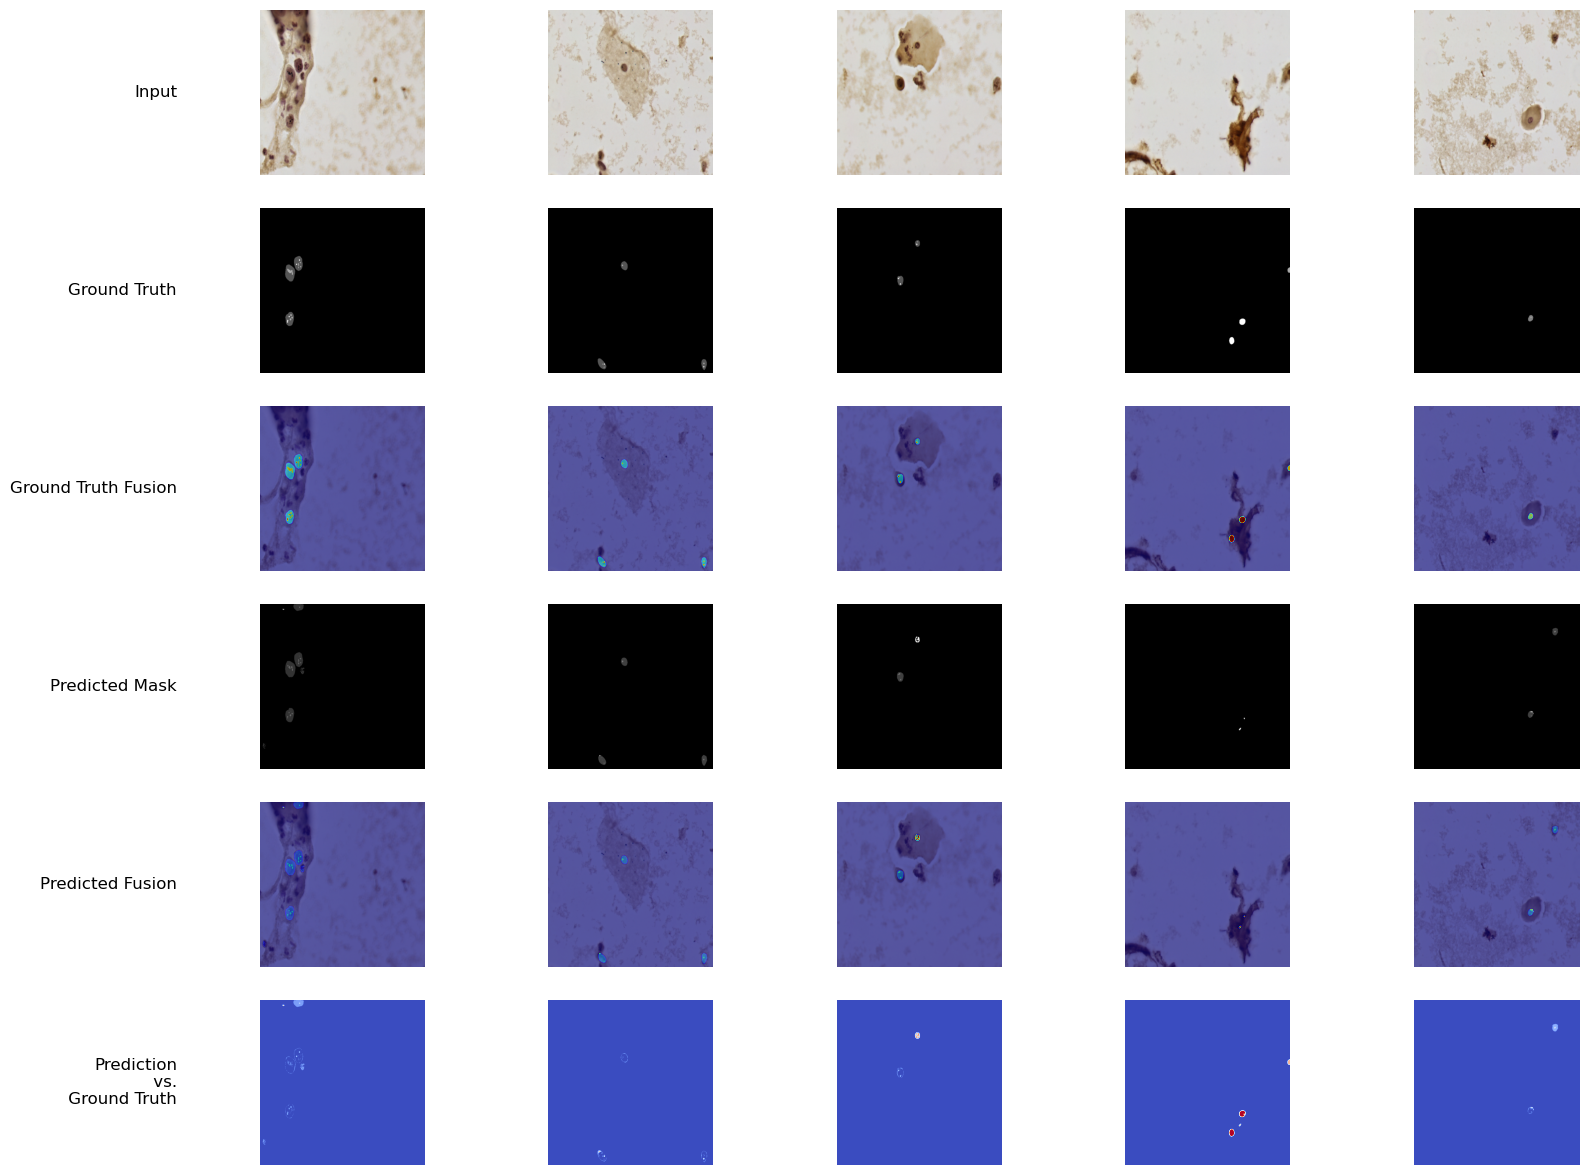

In [89]:
model = UNet(n_channels=3, n_classes=8)
model.load_state_dict(torch.load('checkpoint/model_checkpoint_epoch.pth')) 

model.eval()
predictions = []
with torch.no_grad():
    fig, axs = plt.subplots(6, 5, figsize=(18, 15))  
    
    for i in range(5):  
        random_number = random.randint(1,1868)
        rand_list.append(random_number)
        image, masks = test_dataset[random_number]
        image = image.unsqueeze(0)  
        masks_pred = model(image)

        prob = torch.softmax(masks_pred, dim=1)
        predicted_mask = torch.argmax(prob, dim=1).squeeze(0).cpu().numpy()

        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        
        axs[0, i].imshow(image_np)
        axs[0, i].axis('off')

        axs[1, i].imshow(masks.squeeze(), cmap='gray')
        axs[1, i].axis('off')

        axs[2, i].imshow(image_np)
        axs[2, i].imshow(masks.squeeze(), cmap='jet', alpha=0.6)
        axs[2, i].axis('off')

        axs[3, i].imshow(predicted_mask, cmap='gray')
        axs[3, i].axis('off')

        axs[4, i].imshow(image_np)
        axs[4, i].imshow(predicted_mask, cmap='jet', alpha=0.6)
        axs[4, i].axis('off')

        difference = np.abs(masks.squeeze() - predicted_mask)
        axs[5, i].imshow(difference, cmap='coolwarm')
        axs[5, i].axis('off')

    labels = ['Input', 'Ground Truth', 'Ground Truth Fusion', 'Predicted Mask', 'Predicted Fusion', 'Prediction\n vs.\n Ground Truth']
    for i, label in enumerate(labels):
        axs[i, 0].annotate(label, xy=(-0.5, 0.5),
                    xycoords='axes fraction', xytext=(0, 0), textcoords='offset points',
                    fontsize=12, ha='right', va='center')
